# Crime na Região Metropolitana de São Paulo: uma Análise Exploratória e Geoespacial

A criminalidade na maior metrópole da América Latina é uma questão histórica de grande preocupação tanto para a população quanto para as autoridades de segurança pública. O impacto do crime nessas áreas vai além dos prejuízos materiais, afetando a qualidade de vida, a sensação de segurança e o desenvolvimento social. Compreender os padrões espaciais e temporais dos crimes é essencial para direcionar recursos de forma eficiente e reforçar a presença policial onde ela é mais necessária. Esta análise tem como objetivo principal identificar as áreas dentro da região metropolitana que apresentam maiores índices de criminalidade, com a intenção de fornecer _insights_ valiosos para a alocação estratégica de policiamento e outras medidas de segurança.

A análise será dividida em quatro partes:
- Preparação dos conjuntos de dados para análise exploratória e geoespacial;
- Análise exploratória e geoespacial da criminalidade;
- Preparação das _features_ para o posterior treinamento de um modelo de aprendizado de máquina;
- Treinamento, teste e verificação do modelo de aprendizado de máquina.

Os conjuntos de dados utilizados foram [], obitdos em []. 

## Preparação dos Conjuntos de Dados

In [ ]:
import os
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import textdistance as txd
import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [2]:
def PreProcessamento(palavra):

    nova_palavra = palavra
    if isinstance(palavra, str):

        nova_palavra = nova_palavra.replace('ç', 'c')
        nova_palavra = nova_palavra.replace('ú', 'u')
        nova_palavra = nova_palavra.replace('í', 'i')
        nova_palavra = nova_palavra.replace('â', 'a')
        nova_palavra = nova_palavra.replace('ã', 'a')
        nova_palavra = nova_palavra.replace('á', 'a')
        nova_palavra = nova_palavra.replace('é', 'e')
        nova_palavra = nova_palavra.replace('ê', 'e')
        nova_palavra = nova_palavra.strip().upper()

    return nova_palavra


In [3]:
def PalavraMaisProxima(cidade, ibge_data):

    # cidade = 'SEVERÍNIA'
    lista_ibge = ibge_data['municipio'].unique()
    cidade = cidade.strip()
    equal_word = 'palavraabsolutamentealeatoriataoaleatoriaqueadistanciaehenorme'
    distancia = txd.levenshtein(cidade, equal_word)

    for palavra in lista_ibge:
        if type(palavra) == str:
            nova_distancia = txd.levenshtein(cidade, palavra)
            if nova_distancia < distancia:
                distancia = nova_distancia
                equal_word = palavra

    return equal_word

In [4]:
def CorrigirCidade(nome_cidade):
    if isinstance(nome_cidade, str):
        nome_cidade = nome_cidade.strip()
        if nome_cidade == 'S.PAULO':
            return 'SAO PAULO'
        elif nome_cidade == 'S.BERNARDO DO CAMPO':
            return 'SAO BERNARDO DO CAMPO'
        elif nome_cidade == 'S.ANDRE':
            return 'SANTO ANDRE'
        elif nome_cidade == 'S.CAETANO DO SUL':
            return 'SAO CAETANO DO SUL'
        elif nome_cidade == 'S.ISABEL':
            return 'SANTA ISABEL'
        elif nome_cidade == 'S.LOURENCO DA SERRA':
            return 'SAO LOURENCO DA SERRA'
        elif nome_cidade == 'S.VICENTE':
            return 'SAO VICENTE'
        elif nome_cidade == 'S.ROQUE':
            return 'SAO ROQUE'
    return nome_cidade

In [5]:
def CorrecaoHorario(hora):

    string_hora = str(hora)
    n_hora = string_hora[0:2] + ':' + string_hora[-2:] 

    return n_hora

In [6]:
def CategorizarHorario(horario):
    if pd.isna(horario):
        return np.nan
    elif 0 <= horario.hour < 6:
        return 'Madrugada'
    elif 6 <= horario.hour < 12:
        return 'Manhã'
    elif 12 <= horario.hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

In [ ]:
def dropa_coluna_vazia(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove colunas cujo nome é vazio, só espaços ou do tipo 'Unnamed: 0', 'Unnamed: 1', etc.
    """
    empty_name = df.columns.str.strip() == ""                 # nomes vazios
    unnamed    = df.columns.str.match(r"^Unnamed:\s*\d+$")    # Unnamed: N
    mask = empty_name | unnamed
    return df.loc[:, ~mask]      # mantém apenas as que NÃO estão no mask


In [7]:
#IMPORTA TODOS OS DATAFRAMES DE BO'S:


df_dicio = {}

directory = os.listdir('/home/thiago/python-projects/crime-sp/data/raw/')

for file in directory:
    if file != 'auxiliar':
        if file.startswith('RDO'):
            nome_filev = file
            df_v = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_filev)
            nome_key = file[:-4]
            df_dicio[nome_key] = df_v


        elif file[:-4][-1] == '1':        #para os files que representam 1o semestres:
            for file2 in directory:
                if (file != file2) and (file[:-5] == file2[:-5]):       #encontrando o 2o semestre do ano em questao:
                    nome_file1 = file
                    nome_file2 = file2
                    df1 = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file1)
                    df2 = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file2)

                    nome_key = file[:-6]

                    df_dicio[nome_key] = pd.concat([df1 ,df2], ignore_index=True)   #juntando os dois semestres.

        elif (file[:-4][-1] != '1') and (file[:-4][-1] != '2'):       #para os files que nao sao subdivididos em 2 semestres:
            nome_file = file
            df = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file)
            nome_key = file[:-4]
            df_dicio[nome_key] = df


/tmp/ipykernel_3766/246544369.py:31: DtypeWarning: Columns (19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file)
/tmp/ipykernel_3766/246544369.py:22: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file1)
/tmp/ipykernel_3766/246544369.py:23: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file2)
/tmp/ipykernel_3766/246544369.py:22: DtypeWarning: Columns (15,17,18,21,44,45,47,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/home/thiago/python-projects/crime-sp/data/raw/' + nome_file1)
/tmp/ipykernel_3766/246544369.py:22: DtypeWarning: Columns (26,32,33) have mixed types. Sp

In [ ]:
# ????????? APARENTEMENTE ESSA CELULA NAO SÓ É DESNECESSARIA COMO FODE TODO O CODIGO. NAO RODAR.

# PADRONIZAR A COLUNA COM NOME CIDADES EM TODOS OS DATAFRAMES

# for nome in ['RDO_1', 'RDO_2', 'RDO_3']:
#     df = df_dicio[nome]
#     df = df.rename(columns={'NOME_MUNICIPIO_CIRC': 'CIDADE'})
#     df_dicio[nome] = df

In [8]:
df_dicio['RDO_3']['CIDADE'] = df_dicio['RDO_3']['CIDADE'].apply(CorrigirCidade)
df_dicio['RDO_3']['CIDADE']

0         SAO PAULO
1         SAO PAULO
2         SAO PAULO
3         SAO PAULO
4         SAO PAULO
            ...    
553424    SAO PAULO
553425    SAO PAULO
553426    SAO PAULO
553427    SAO PAULO
553428    SAO PAULO
Name: CIDADE, Length: 553429, dtype: object

In [9]:
#PREPROCESSAMENTO DA COLUNA 'CIDADE' DE CADA DATAFRAME DE BO'S:

for key in df_dicio.keys():
    df_dicio[key]['CIDADE'] = df_dicio[key]['CIDADE'].apply(CorrigirCidade)

In [11]:
# #OS RDOS ESTAO BAGUNCADOS. ANOS DIVERSOS EM CADA UM. FAZ-SE UM DATAFRAME PARA CADA ANO, DE 2010 A 2016:


# for ano in [2010, 2011, 2012, 2013, 2014, 2015, 2016]:

#     df_rdo1 = df_dicio['RDO_1'].copy()
#     df_rdo1 = df_rdo1.loc[df_rdo1['ANO_BO'] == ano]

#     df_rdo2 = df_dicio['RDO_2'].copy()
#     df_rdo2 = df_rdo1.loc[df_rdo2['ANO_BO'] == ano]

#     df_rdo3 = df_dicio['RDO_3'].copy()
#     df_rdo3 = df_rdo3.loc[df_rdo3['ANO_BO'] == ano]

#     df = pd.concat([df_rdo1, df_rdo2, df_rdo3], ignore_index=True)
#     nome_key = 'BO_' + str(ano) + '_v'
#     df_dicio[nome_key] = df



#OS RDOS ESTAO BAGUNCADOS. ANOS DIVERSOS EM CADA UM. FAZ-SE UM DATAFRAME PARA CADA ANO, DE 2010 A 2016:
## ACHO QUE CORRIGI O ERRO ANTERIOR.


for ano in [2010, 2011, 2012]:

    df_rdo1 = df_dicio['RDO_1'].copy()
    df_rdo1 = df_rdo1.loc[df_rdo1['ANO_BO'] == ano]

    nome_key = 'BO_' + str(ano) + '_v'
    df_dicio[nome_key] = df_rdo1

for ano in [2013, 2014, 2015]:

    df_rdo2 = df_dicio['RDO_2'].copy()
    df_rdo2 = df_rdo1.loc[df_rdo2['ANO_BO'] == ano]

    nome_key = 'BO_' + str(ano) + '_v'
    df_dicio[nome_key] = df_rdo2

for ano in [2016, 2017]:

    df_rdo3 = df_dicio['RDO_3'].copy()
    df_rdo3 = df_rdo3.loc[df_rdo3['ANO_BO'] == ano]

    nome_key = 'BO_' + str(ano) + '_v'
    df_dicio[nome_key] = df_rdo3

    # df = pd.concat([df_rdo1, df_rdo2, df_rdo3], ignore_index=True)
    # nome_key = 'BO_' + str(ano) + '_v'
    # df_dicio[nome_key] = df


In [12]:
df_dicio['BO_2016_v'].iloc[0]

ID_DELEGACIA                                                           10004
NOME_DEPARTAMENTO                   DIRD - DEPTO IDENT.REG.DIV              
NOME_SECCIONAL                      DIV.POL.PORTO/AERO/PROT.TURIS-DECADE    
NOME_DELEGACIA                                06º D.P. METROPOLITANO        
CIDADE                                                             SAO PAULO
ANO_BO                                                                  2016
NUM_BO                                                                     9
NOME_DEPARTAMENTO_CIRC              DECAP                                   
NOME_SECCIONAL_CIRC                 DEL.SEC.1º CENTRO                       
NOME_DELEGACIA_CIRC                           08º D.P. BRAS                 
NOME_MUNICIPIO_CIRC                           S.PAULO                       
DESCR_TIPO_BO                       Boletim de Ocorrência                   
DATA_OCORRENCIA_BO                                                04/01/2016

In [13]:
#IMPORTA O DATAFRAME DO IBGE (com a populacao de cada municipio em cada ano):

ibge_data = pd.read_csv('/home/thiago/datasets/serie_populacao2000a2023.csv', encoding= 'ISO-8859-1', sep=';')

In [14]:
#PREPROCESSAMENTO DA COLUNA MUNICIPIOS DO DATAFRAME DO IBGE:

# for i in range(len(ibge_data)):
#     if type(ibge_data['municipio'][i]) == str:
#         nome = ibge_data['municipio'][i]
        
#         ##modo errado no pandas 3.0:
#         # ibge_data['municipio'][i] = PreProcessamento(nome)

#         #modo correto no pandas 3.0 (pandas gritou comigo):
#         ibge_data.loc[i, 'municipio'] = PreProcessamento(nome)


# MODO MAIS EFICIENTE:
ibge_data['municipio'] = ibge_data['municipio'].apply(PreProcessamento)


    

## Análise Exploratória e Geoespacial

### Análise Temporal

Primeiramente, será feita uma análise temporal acerca dos BO's. Isto inclui a evolução anual de BO's registrados, evolução mensal para um ano específico, e como se distribuem em relação ao horário do dia. Isto será utilizado posteriormente para algumas tipificações específicas de crimes (Furto e Roubo, por exemplo).

É sabido que, em número absolutos, a cidade de São Paulo é a que contém mais crimes entre seus municípios vizinhos. É também, no entanto, a mais populosa. Por tanto, é necessário analisar a taxa de crime por habitante. Para tal, será utilizado o conjunto fornecido pelo Instituto Brasileiro de Geografia e Estatística (IBGE), que contém a população estimada de cada município entre os anos 2000 e 2020 da região metropolitana, para cruzarmos com o primeiro.

#### Taxa de Criminalidade x Anos

In [15]:
#CRIACAO DO NOVO DATAFRAME COM A RAZAO DE 'CRIMES : POPULACAO' DE CADA MUNICIPIO EM CADA ANO (APENAS PARA BOS FEITOS PRESENCIALMENTE):


lista_ssp = df_dicio['BO_2016']['CIDADE'].unique()
dicio_rcrimes = {}

for cidade in lista_ssp:
    if type(cidade) == str:
        # cidade = cidade.strip()
        cidade_dicio = {}

        for ano in [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]:
            df_ano = df_dicio['BO_' + str(ano)]
            filtro_BO = (df_ano['CIDADE'] == cidade)
            quant_crimes = len(df_ano[filtro_BO])

            cidade_prep = PalavraMaisProxima(cidade, ibge_data)
            filtro_ibge = (ibge_data['municipio'] == cidade_prep) & (ibge_data['ano'] == float(ano))
            pop_total = ibge_data.loc[filtro_ibge]['pop_total']     #isso é uma pd.Series. tenho que pegar o unico valor dele.
            pop_total = pop_total.iloc[0]                           #feito.

            razao_crimes = quant_crimes / pop_total

            cidade_dicio[ano] = razao_crimes
        
        cidade = cidade.strip()
        dicio_rcrimes[cidade] = cidade_dicio


In [16]:
#CRIACAO DO NOVO DATAFRAME COM A RAZAO DE 'CRIMES : POPULACAO' DE CADA MUNICIPIO EM CADA ANO (APENAS PARA BOS FEITOS VIRTUALMENTE):


df_dicio['RDO_1'] = df_dicio['RDO_1'].loc[:, ~df_dicio['RDO_1'].columns.duplicated()]
# df_dicio['RDO_1'] = df_dicio['RDO_1'][~df_dicio['RDO_1'].index.duplicated(keep='first')]


lista_ssp_v = df_dicio['RDO_1']['CIDADE'].unique()
dicio_rcrimes_v = {}

for cidade in lista_ssp_v:
    if type(cidade) == str:
        # cidade = cidade.strip()
        cidade_dicio = {}

        for ano in [2010, 2011, 2012, 2013, 2014, 2015, 2016]:
            nome_file = 'BO_' + str(ano) + '_v'

            df_dicio[nome_file] = df_dicio[nome_file].loc[:, ~df_dicio[nome_file].columns.duplicated()]

            df_ano = df_dicio[nome_file]
            filtro_BO = df_ano['CIDADE'] == cidade
            quant_crimes = len(df_ano[filtro_BO])

            cidade_prep = CorrigirCidade(PreProcessamento(cidade))

            cidade_prep = PalavraMaisProxima(cidade_prep, ibge_data)
            filtro_ibge = (ibge_data['municipio'] == cidade_prep) & (ibge_data['ano'] == float(ano))        #filtrando o dataset do ibge com a cidade especifica e o ano especifico.
            pop_total = ibge_data.loc[filtro_ibge]['pop_total']     #isso é uma pd.Series. tenho que pegar o unico valor dele.
            pop_total = pop_total.iloc[0]                           #feito.

            razao_crimes = quant_crimes / pop_total

            cidade_dicio[ano] = razao_crimes
        
        cidade = CorrigirCidade(cidade.strip())
        
        dicio_rcrimes_v[cidade] = cidade_dicio

In [17]:
# print("Colunas duplicadas:", df_dicio['RDO_1'].columns[df_dicio['RDO_1'].columns.duplicated()].unique())

In [18]:
df_rcrimes = pd.DataFrame.from_dict(dicio_rcrimes, orient='index')
df_rcrimes_v = pd.DataFrame.from_dict(dicio_rcrimes_v, orient='index')
df_rcrimes_total = df_rcrimes + df_rcrimes_v

Criados dataframes específicos para a análise de taxa de crimes em relação à população de cada município, é possível encontrar os municípios com maior e menor taxa de crime:

In [19]:
df_rcrimes.loc[df_rcrimes[2016].idxmax()]

2007    0.068874
2008    0.074273
2009    0.085646
2010    0.081871
2011    0.091710
2012    0.087748
2013    0.107753
2014    0.110581
2015    0.044599
2016    0.045298
Name: DIADEMA, dtype: float64

In [20]:
df_rcrimes.loc[df_rcrimes[2016].idxmin()]

2007    1.817477e-05
2008    1.325414e-05
2009    1.686307e-05
2010    2.501992e-05
2011    1.917049e-04
2012    9.075275e-05
2013    0.000000e+00
2014    5.165734e-05
2015    9.006810e-07
2016    8.954740e-07
Name: CAMPINAS, dtype: float64

Em relação ao ano de 2016, Diadema e Campinas são os municípios com maior e menor taxa de crimes em relação a população, respectivamente. Ainda, notam-se algumas particularidades: Tanto Diadema quanto Campinas parecem ter tido uma visível redução da taxa de criminalidade. Verificaremos se essa queda se verifica na média da taxa de criminalidade entre municípios no decorrer dos anos:

In [21]:
df_rcrimes.mean()

2007    0.036253
2008    0.035782
2009    0.037784
2010    0.036679
2011    0.038716
2012    0.039407
2013    0.042639
2014    0.043258
2015    0.017030
2016    0.016559
dtype: float64

In [22]:
df_t = df_rcrimes.T
df_vt = df_rcrimes_v.T

In [23]:
df_vt


SAO PAULO  GUARULHOS  APARECIDA   LIMEIRA   DIADEMA  PERUIBE  Sao Paulo
2010   0.032442   0.000002   0.000029  0.000004  0.000003      0.0        0.0
2011   0.034565   0.000000   0.000000  0.000000  0.000000      0.0        0.0
2012   0.003167   0.000000   0.000000  0.000000  0.000000      0.0        0.0
2013   0.001103   0.000000   0.000000  0.000000  0.000000      0.0        0.0
2014   0.001118   0.000000   0.000000  0.000000  0.000000      0.0        0.0
2015   0.000920   0.000000   0.000000  0.000000  0.000000      0.0        0.0
2016   0.044437   0.000055   0.000000  0.000000  0.000200      0.0        0.0

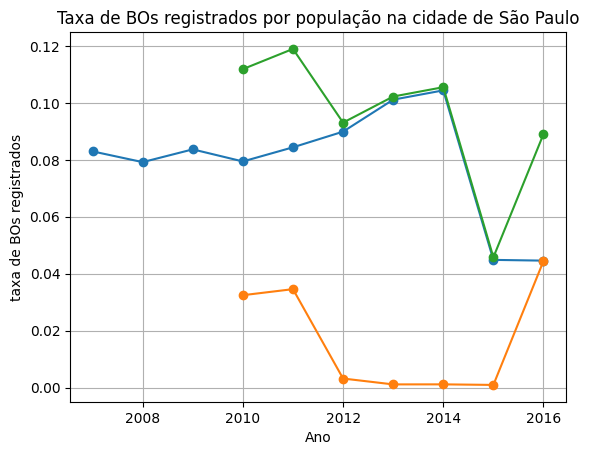

In [24]:
coluna_especifica = df_t['SAO PAULO']
coluna_especifica2 = df_vt['SAO PAULO']
coluna_especifica3 = (df_t['SAO PAULO'] + df_vt['SAO PAULO'])

# # Plotar a coluna específica
coluna_especifica.plot(kind='line', marker='o')
coluna_especifica2.plot(kind='line', marker='o')
coluna_especifica3.plot(kind='line', marker='o')

# Configurações adicionais
plt.title('Taxa de BOs registrados por população na cidade de São Paulo')
plt.xlabel('Ano')
plt.ylabel('taxa de BOs registrados')
plt.grid(True)

# Mostrar o gráfico
plt.show()

In [25]:
filtro = (ibge_data['municipio'] == 'ADAMANTINA') & (ibge_data['ano'] == 2007.0)
ibge_data.loc[filtro]['pop_total']

7    33791.0
Name: pop_total, dtype: float64

In [26]:
ibge_data['municipio'] == 'ADAMANTINA'

0         True
1         True
2         True
3         True
4         True
         ...  
15476    False
15477    False
15478    False
15479    False
15480    False
Name: municipio, Length: 15481, dtype: bool

#### Densidade Criminal por Horário

In [27]:
df_dicio['BO_2016_v'].columns

Index(['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 'NOME_DELEGACIA',
       'CIDADE', 'ANO_BO', 'NUM_BO', 'NOME_DEPARTAMENTO_CIRC',
       'NOME_SECCIONAL_CIRC', 'NOME_DELEGACIA_CIRC', 'NOME_MUNICIPIO_CIRC',
       'DESCR_TIPO_BO', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA_BO',
       'DATAHORA_COMUNICACAO_BO', 'FLAG_STATUS', 'RUBRICA', 'DESCR_CONDUTA',
       'DESDOBRAMENTO', 'DESCR_TIPOLOCAL', 'DESCR_SUBTIPOLOCAL', 'LOGRADOURO',
       'NUMERO_LOGRADOURO', 'LATITUDE', 'LONGITUDE', 'DESCR_TIPO_PESSOA',
       'FLAG_VITIMA_FATAL', 'SEXO_PESSOA', 'IDADE_PESSOA', 'COR_CUTIS',
       'Unnamed: 30'],
      dtype='object')

In [28]:
df_dicio['BO_2016_v']['HORA_OCORRENCIA_BO'] = df_dicio['BO_2016_v']['HORA_OCORRENCIA_BO'].apply(CorrecaoHorario) 

In [29]:
#errors='coerce' transforma qualquer valor inválido em NaT (Not a Time), que é o equivalente a NaN para datetime.
df_dicio['BO_2016_v']['HORARIO'] = pd.to_datetime(df_dicio['BO_2016_v']['HORA_OCORRENCIA_BO'], format='%H:%M',errors='coerce')

In [30]:
df_dicio['BO_2016_v']['HORARIO']

0        1900-01-01 18:15:00
1        1900-01-01 12:30:00
2        1900-01-01 22:30:00
3        1900-01-01 19:00:00
4        1900-01-01 17:20:00
                 ...        
553423   1900-01-01 09:00:00
553424                   NaT
553425                   NaT
553426                   NaT
553427                   NaT
Name: HORARIO, Length: 509087, dtype: datetime64[ns]

In [31]:
df_dicio['BO_2016_v']['PERIODO'] = df_dicio['BO_2016_v']['HORARIO'].apply(CategorizarHorario)

In [32]:
df_dicio['BO_2016_v']['PERIODO']

0         Noite
1         Tarde
2         Noite
3         Noite
4         Tarde
          ...  
553423    Manhã
553424      NaN
553425      NaN
553426      NaN
553427      NaN
Name: PERIODO, Length: 509087, dtype: object

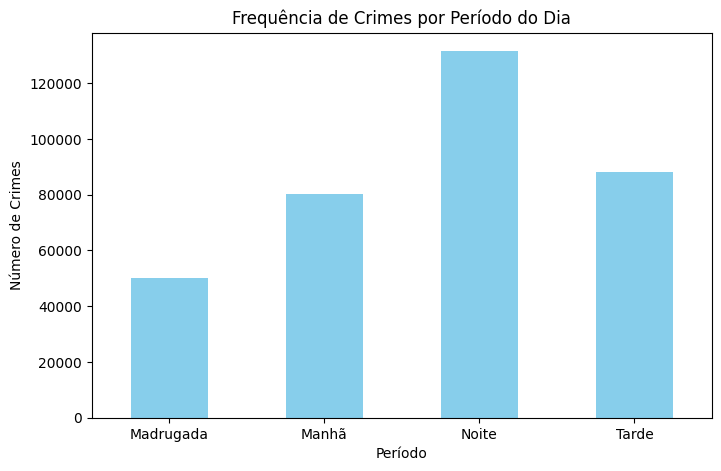

In [33]:
frequencias = df_dicio['BO_2016_v']['PERIODO'].value_counts().sort_index()

# Plotando o gráfico de barras
plt.figure(figsize=(8, 5))
frequencias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Crimes por Período do Dia')
plt.xlabel('Período')
plt.ylabel('Número de Crimes')
plt.xticks(rotation=0)
plt.show()

In [34]:
df_dicio['BO_2016_v']['PERIODO'].unique()

array(['Noite', 'Tarde', 'Manhã', 'Madrugada', nan], dtype=object)

In [35]:
# Inicializando o dicionário para armazenar os mapas por período
mapas_por_periodo = {}

# Bins dos períodos
bins = ['Madrugada', 'Manhã', 'Tarde', 'Noite']

# Limpa as colunas LATITUDE e LONGITUDE
df_dicio['BO_2016_v']['LATITUDE'] = pd.to_numeric(df_dicio['BO_2016_v']['LATITUDE'], errors='coerce')
df_dicio['BO_2016_v']['LONGITUDE'] = pd.to_numeric(df_dicio['BO_2016_v']['LONGITUDE'], errors='coerce')

# Iterando pelos períodos (bins)
for bin in bins:
    # Filtrando os dados para o período atual
    df_bin = df_dicio['BO_2016_v'][df_dicio['BO_2016_v']['PERIODO'] == bin]

    # Criando o mapa
    mapa = folium.Map(location=[-23.55, -46.63], zoom_start=11)

    # Criando a lista de pontos para o HeatMap
    pontos = df_bin[['LATITUDE', 'LONGITUDE']].dropna().values.tolist()

    # Adicionando o HeatMap ao mapa
    HeatMap(pontos, radius=9).add_to(mapa)
    
    # Salvando o mapa na variável correspondente ao período
    mapas_por_periodo[bin] = mapa

# Para visualizar um dos mapas, use o comando a seguir, exemplo:
mapas_por_periodo['Tarde']


In [36]:
mapas_por_periodo['Noite']

In [37]:
mapas_por_periodo['Madrugada']

In [38]:
for bin in bins:
    df_bin = df_dicio['BO_2016_v'][df_dicio['BO_2016_v']['PERIODO'] == bin]
    print(f"Período: {bin}, Registros: {df_bin.shape[0]}")
    # ... resto do código



Período: Madrugada, Registros: 50135
Período: Manhã, Registros: 80437
Período: Tarde, Registros: 88076
Período: Noite, Registros: 131561


#### Análise de Frequência Criminal mês a mês

In [39]:
df_dicio['BO_2016_v']['DATA_OCORRENCIA_BO'][0]

'04/01/2016'

In [40]:
# df_dicio['BO_2016_v'].iloc[0]['DATA_OCORRENCIA_BO']

df_dicio['BO_2016_v']['DATA_OCORRENCIA_BO'] = pd.to_datetime(df_dicio['BO_2016_v']['DATA_OCORRENCIA_BO'], format='%d/%m/%Y')

df_dicio['BO_2016_v']['MES'] = df_dicio['BO_2016_v']['DATA_OCORRENCIA_BO'].dt.month

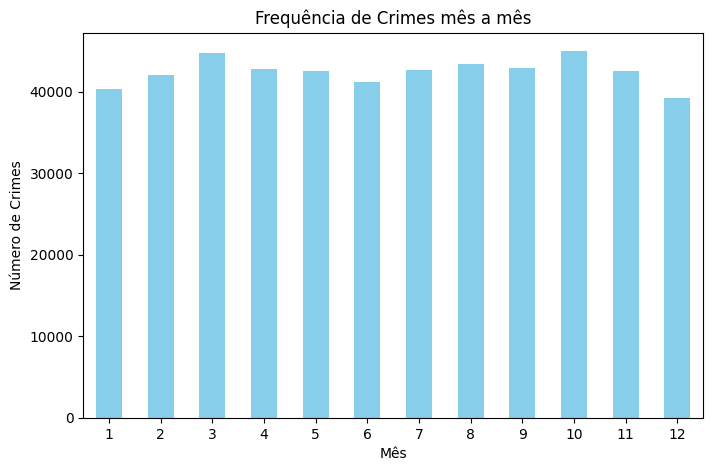

In [41]:
frequencias = df_dicio['BO_2016_v']['MES'].value_counts().sort_index()

# Plotando o gráfico de barras
plt.figure(figsize=(8, 5))
frequencias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Crimes mês a mês')
plt.xlabel('Mês')
plt.ylabel('Número de Crimes')
plt.xticks(rotation=0)
plt.show()

### Análise por Tipificação e Policiamento Necessário

In [42]:
filtro = ( df_dicio['BO_2016_v']['RUBRICA'] == 'Homicídio simples (art. 121)' ) | ( df_dicio['BO_2016_v']['RUBRICA'] == 'Homicídio qualificado (art. 121, §2o.)' ) | ( df_dicio['BO_2016_v']['RUBRICA'] == 'A.I.-Homicídio qualificado (art. 121, §2o.)' ) | (df_dicio['BO_2016_v']['RUBRICA'] == 'A.I.-Homicídio simples (art. 121)' )


df_bin = df_dicio['BO_2016_v'][filtro]

# Criando o mapa
mapa = folium.Map(location=[-23.55, -46.63], zoom_start=11)

# Criando a lista de pontos para o HeatMap
pontos = df_bin[['LATITUDE', 'LONGITUDE']].dropna().values.tolist()

# Adicionando o HeatMap ao mapa
HeatMap(pontos, radius=10).add_to(mapa)

# Salvando o mapa na variável correspondente ao período
mapa

In [56]:
set_crimes = set()
for key in df_dicio.keys():
    set_crimes = set_crimes.union( set(df_dicio[key]['RUBRICA'].unique()) )

lista_crimes = list(set_crimes)

In [57]:
lista_crimes

['Homicídio culposo (art. 121, §3o.)',
 'A.I.-Induzir, instigar ou auxiliar alguém ao uso indevido de droga(Art.33,§2º)',
 'Homicídio culposo na direção de veículo automotor (Art. 302)',
 'A.I.-Furto (art. 155)',
 'Roubo (art. 157)',
 'A.I.-Lesão corporal de natureza GRAVE (art. 129, §1o.)',
 'Induzir, instigar ou auxiliar alguém ao uso indevido de droga(Art.33,§2º)',
 'Tráfico de entorpecente (Art. 12)',
 'A.I.-Homicídio simples (art. 121)',
 'Furto de coisa comum (art. 156)',
 'Lesão corporal culposa (art. 129. §6o.)',
 'A.I.-Porte de objeto destinado à fabricação de entorpecente (Art. 13)',
 'Drogas sem autorização ou em desacordo (Art.33, caput)',
 'A.I.-Homicídio culposo (art. 121, §3o.)',
 'A.I.-Lesão corporal culposa na direção de veículo automotor (Art. 303)',
 'Lesão corporal seguida de morte (art. 129, §3o.)',
 'Porte de objeto destinado à fabricação de entorpecente (Art. 13)',
 'A.I.-Lesão corporal (art 129 § 9º)',
 'A.I.-Furto de coisa comum (art. 156)',
 'Lesão corporal (a

In [44]:
# Coluna contendo uma categorização em relação a cada crime. Divididos entre Pouco grave, medio grave, muito grave e crime de transito. (será?)

crime_categorizacao = {
    'Policiamento Comunitário': [
        'Lesão corporal (art. 129)',
        'Lesão corporal (art 129 § 9º)',
        'Lesão corporal culposa (art. 129. §6o.)',
        'Lesão corporal culposa na direção de veículo automotor (Art. 303)',
        'Lesão corporal de natureza GRAVE (art. 129, §1o.)',
        "Lesão corporal  de natureza 'GRAVÍSSIMA' (art. 129, §2o.)",
        'Lesão corporal seguida de morte (art. 129, §3o.)',
        'A.I.-Lesão corporal (art. 129)',
        'A.I.-Lesão corporal (art 129 § 9º)',
        'A.I.-Lesão corporal culposa (art. 129. §6o.)',
        'A.I.-Lesão corporal de natureza GRAVE (art. 129, §1o.)'
    ],
    
    'Policiamento Tático': [
        'Roubo (art. 157)',
        'Homicídio simples (art. 121)',
        'Homicídio qualificado (art. 121, §2o.)',
        'Estupro (art.213)',
        'Estupro de vulneravel (art.217-A)',
        'A.I.-Roubo (art. 157)',
        'A.I.-Homicídio simples (art. 121)',
        'A.I.-Homicídio qualificado (art. 121, §2o.)',
        'A.I.-Estupro (art.213)',
        'A.I.-Estupro de vulneravel (art.217-A)'
    ],
    
    'Policiamento Preventivo': [
        'Furto qualificado (art. 155, §4o.)',
        'Furto (art. 155)',
        'Furto de coisa comum (art. 156)',
        'A.I.-Furto qualificado (art. 155, §4o.)',
        'A.I.-Furto (art. 155)',
        'A.I.-Furto de coisa comum (art. 156)',
    ],
    
    'Policiamento de Trânsito': [
        'Homicídio culposo na direção de veículo automotor (Art. 302)',
        'A.I.-Homicídio culposo na direção de veículo automotor (Art. 302)',
        'Lesão corporal culposa na direção de veículo automotor (Art. 303)',
        'A.I.-Lesão corporal culposa na direção de veículo automotor (Art. 303)',
    ]
}


In [45]:
def mapear_policiamento(crime):
    for tipo_policiamento, crimes in crime_categorizacao.items():
        if crime in crimes:
            return tipo_policiamento
    return 'Desconhecido'

In [46]:
df_dicio['BO_2016_v']['TIPO POLICIAMENTO'] = df_dicio['BO_2016_v']['RUBRICA'].apply(mapear_policiamento)

In [47]:
df_dicio['BO_2016']['TIPO POLICIAMENTO'] = df_dicio['BO_2016']['RUBRICA'].apply(mapear_policiamento)

In [48]:
print(df_dicio['BO_2016'][['RUBRICA', 'TIPO POLICIAMENTO']].head())

                                             RUBRICA         TIPO POLICIAMENTO
0                                   Furto (art. 155)   Policiamento Preventivo
1                                   Roubo (art. 157)       Policiamento Tático
2  Drogas sem autorização ou em desacordo (Art.33...              Desconhecido
3                                   Roubo (art. 157)       Policiamento Tático
4                          Lesão corporal (art. 129)  Policiamento Comunitário


In [49]:
print(df_dicio['BO_2016_v'][['RUBRICA', 'TIPO POLICIAMENTO']].head())

                                   RUBRICA        TIPO POLICIAMENTO
0       Furto qualificado (art. 155, §4o.)  Policiamento Preventivo
1                         Roubo (art. 157)      Policiamento Tático
2                         Roubo (art. 157)      Policiamento Tático
3                         Roubo (art. 157)      Policiamento Tático
4  A.I.-Furto qualificado (art. 155, §4o.)  Policiamento Preventivo


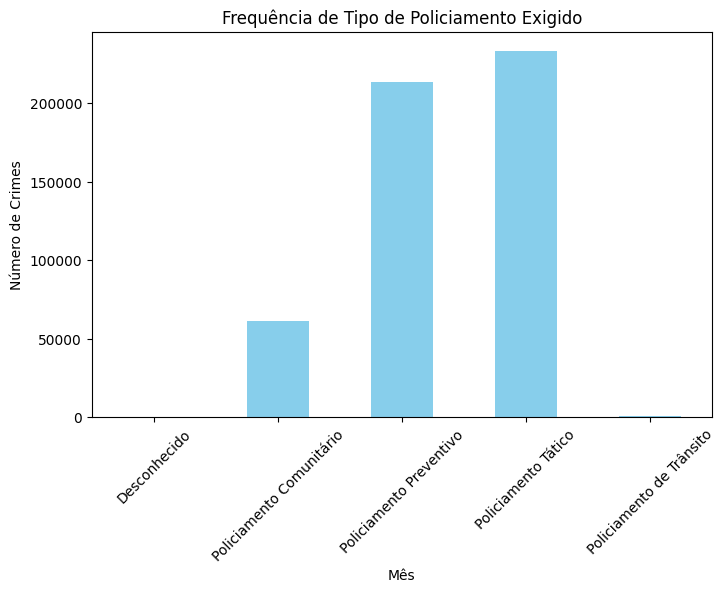

In [50]:
frequencias = df_dicio['BO_2016_v']['TIPO POLICIAMENTO'].value_counts().sort_index()

# Plotando o gráfico de barras
plt.figure(figsize=(8, 5))
frequencias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Tipo de Policiamento Exigido')
plt.xlabel('Mês')
plt.ylabel('Número de Crimes')
plt.xticks(rotation=45)
plt.show()

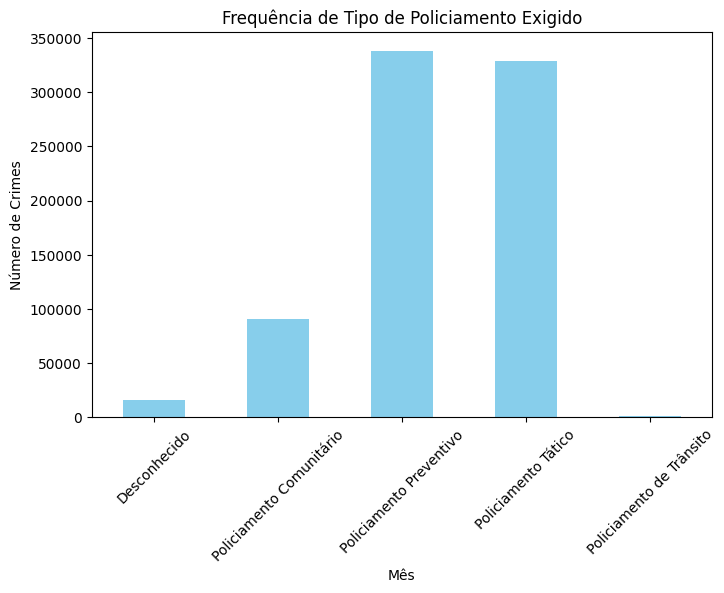

In [51]:
frequencias = df_dicio['BO_2016']['TIPO POLICIAMENTO'].value_counts().sort_index()

# Plotando o gráfico de barras
plt.figure(figsize=(8, 5))
frequencias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Tipo de Policiamento Exigido')
plt.xlabel('Mês')
plt.ylabel('Número de Crimes')
plt.xticks(rotation=45)
plt.show()